In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
tfe.enable_eager_execution()

In [3]:
NUM_EPOCHES = 4 # ADJUST
BATCH_SIZE = 64 # ADJUST
LEARNING_RATE = 0.0001 # ADJUST

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data()
train_images, train_labels = train_data
test_images, test_labels = test_data

train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32)/255
test_images = test_images.reshape(-1, 28, 28, 1).astype(np.float32)/255

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

print('Train images shape: {}'.format(train_images.shape))
print('Test images shape: {}'.format(test_images.shape))

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


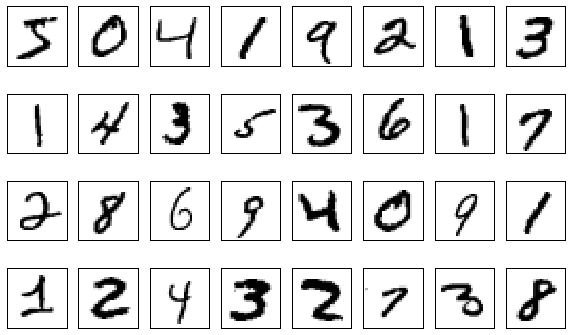

In [5]:
some_samples = train_images[:32, :, :, 0].transpose(1, 2, 0)

fig = plt.figure(figsize=(10,6))
for j in range(some_samples.shape[2]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[:,:,j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(60000).batch(BATCH_SIZE)

In [7]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.layers.Conv2D(32, (5, 5), activation=tf.nn.relu,
            padding='same',
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        self.conv2 = tf.layers.Conv2D(64, (5, 5), activation=tf.nn.relu,
            padding='same',
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        self.fc1 = tf.layers.Dense(256, activation=tf.nn.relu,
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        self.fc2 = tf.layers.Dense(10, activation=None,
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        self.max_pool = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

    def __call__(self, inp):
        
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = tf.layers.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)  
        
        return out
    
model = Model()

In [8]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

In [9]:
def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
    labels = tf.cast(labels, tf.int64)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), 
        dtype=tf.float32))

In [10]:
# ADJUST
# optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
# LOG_DIR = 'logs/sgd/'
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
LOG_DIR = 'logs/adam/'

In [11]:
writer = tf.contrib.summary.create_file_writer(LOG_DIR)
global_step = tf.train.get_or_create_global_step()

In [12]:
with tf.device("/gpu:0"):
    for ep in range(NUM_EPOCHES):
        for (it, (images, labels)) in enumerate(tfe.Iterator(train_ds)):

            images = images.gpu()
            labels = labels.gpu()

            with tfe.GradientTape() as tape:
                logits = model(images)
                loss_value = loss(logits, labels)

            grads = tape.gradient(loss_value, model.variables)
            optimizer.apply_gradients(zip(grads, model.variables),
                global_step=global_step)

            if it % 200 == 0:
                test_logits = model(test_images[:256])
                accuracy_value = accuracy(test_logits, test_labels[:256])

                print("[%4d] Accuracy: %5.2f %%" % (
                    global_step, accuracy_value.numpy()*100))
                
                with writer.as_default():
                    with tf.contrib.summary.always_record_summaries():
                        tf.contrib.summary.scalar('accuracy', accuracy_value)
                        tf.contrib.summary.scalar('loss', loss_value)


[   1] Accuracy: 10.94 %
[ 201] Accuracy: 92.58 %
[ 401] Accuracy: 95.70 %
[ 601] Accuracy: 98.05 %
[ 801] Accuracy: 97.27 %
[ 939] Accuracy: 98.44 %
[1139] Accuracy: 99.22 %
[1339] Accuracy: 98.05 %
[1539] Accuracy: 98.83 %
[1739] Accuracy: 99.22 %
[1877] Accuracy: 99.22 %
[2077] Accuracy: 99.22 %
[2277] Accuracy: 99.61 %
[2477] Accuracy: 99.61 %
[2677] Accuracy: 99.22 %
[2815] Accuracy: 99.61 %
[3015] Accuracy: 99.22 %
[3215] Accuracy: 99.61 %
[3415] Accuracy: 99.22 %
[3615] Accuracy: 99.61 %


In [13]:
with tf.device("/gpu:0"):
    test_logits = model(test_images)
    accuracy_value = accuracy(test_logits, test_labels).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value*100))

Final Accuracy: 98.15 %


In [14]:
def test_digit(sample):
    
    sample = sample[np.newaxis, ...]
    with tf.device("/gpu:0"):
        logits = model(sample)
    prediction = tf.nn.softmax(logits.cpu()).numpy()
    ans = np.argmax(prediction)

    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample.reshape(28, 28), 
              cmap=matplotlib.cm.binary,interpolation ='none')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid('on')

    plt.show()

    print('Answer: {}'.format(ans))

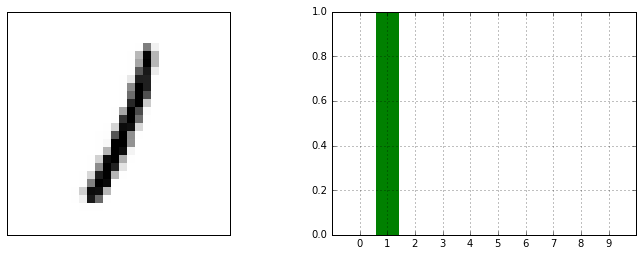

Answer: 1


In [15]:
idx = random.randint(0, test_images.shape[0])
sample = test_images[idx,:]
test_digit(sample)

In [16]:
print('True Answer: {}'.format(test_labels[idx]))

True Answer: 1


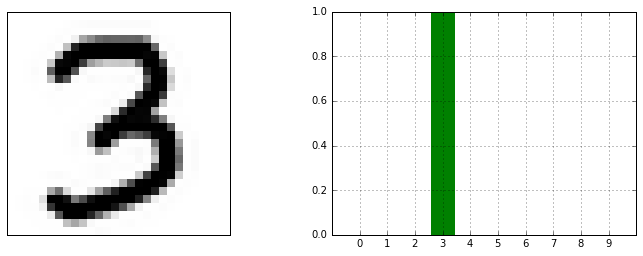

Answer: 3


In [17]:
import scipy.misc

img = scipy.misc.imread('digit.png')
img = scipy.misc.imresize(img, (28, 28), interp='lanczos')

img = 1. - img.astype(np.float32)/255.
img = np.mean(img, axis=2)
img = np.reshape(img, (28, 28, 1))

test_digit(img)

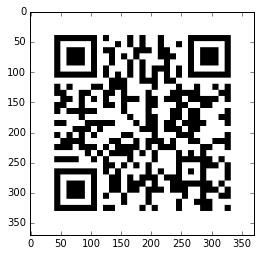

In [18]:
GITHUB_URL = 'https://github.com/dkorobchenko-nv/dl-demo'

import qrcode
fig = plt.figure(figsize=(4, 4))
_=plt.imshow(qrcode.make(GITHUB_URL))